In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from Simulation_Class import *

In [4]:
path = 'D:\Desktop\RND\VolatilitySurface1996_2020.csv'
vol_df = pd.read_csv(path,usecols=['date', 'days', 'impl_volatility', 'impl_strike', 'cp_flag'])  
type(vol_df)
aa = vol_df.head(50)
print((vol_df.columns))
print((vol_df['days'].unique()))
print((vol_df['date'].unique()))
print((len(vol_df['date'].unique())))

Index(['date', 'days', 'impl_volatility', 'impl_strike', 'cp_flag'], dtype='object')
[ 10  30  60  91 122 152 182 273 365 547 730]
[19960104 19960105 19960108 ... 20201229 20201230 20201231]
6293


In [3]:
vol_df.shape

(2353582, 5)

In [ ]:
aa.loc[10:15]

,date,days,impl_volatility,impl_strike,cp_flag
10,19960104,10,NaN,0.0,P
11,19960104,10,NaN,0.0,P
12,19960104,10,NaN,0.0,P
13,19960104,10,NaN,0.0,P
14,19960104,10,NaN,0.0,P
15,19960104,10,NaN,0.0,P


No handles with labels found to put in legend.


Text(0.5, 1.0, 'IVs for date: 20200605 cp_flag: C')

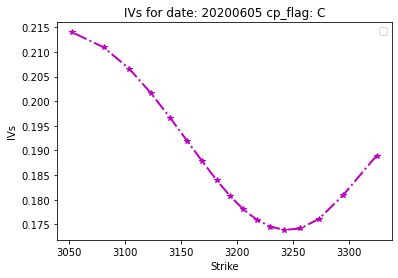

In [5]:
date = 20200605
day = 10
cp_flag = 'C'
dayVol = vol_df.loc[vol_df['date'] == date]
len(dayVol)
drawVol = dayVol[(dayVol['days'] == day) & (dayVol['cp_flag'] == cp_flag)]
len(drawVol)

plt.figure()
plt.plot(drawVol['impl_strike'],
         drawVol['impl_volatility'],
         'm*-.',
         linewidth=2)
plt.legend()
plt.xlabel("Strike")
plt.ylabel("IVs")
plt.title('IVs for date: %d cp_flag: %s' % (date, cp_flag))

In [6]:
dayVol = vol_df.loc[vol_df['date']==date]

In [7]:
rate_path = 'D:\Desktop\RND\InterestRate1996_2020.csv'
st_path = 'D:\Desktop\RND\IndexPrice1996_2020.csv'
optionPrice_path = 'D:\Desktop\RND\SP500OptionPrice1996_2020_2.csv'
rate_df = pd.read_csv(rate_path)


In [73]:
dayRate = rate_df[rate_df['date'] == date]  #先选期权开始日
if dayRate[dayRate['days'] ==
           day].shape[0] > 0:  #再选时长=tau（day），有的话（行数大于零），则直接得到对应利率
    r = dayRate[dayRate['days'] == day].reset_index(drop=True)['rate'][0]
else:
    interpolate = dayRate.append(
        [{
            'date': int(date),
            'days': int(day)
        }], ignore_index=True).sort_values(by=['days']).reset_index(drop=True)
    interpolate = interpolate.interpolate('linear')
    r = interpolate[interpolate['days'] == day].reset_index(
        drop=True)['rate'][0]

In [74]:
r

0.108571

In [9]:
print(vol_df['date'].unique())
print(len(vol_df['date'].unique()))
print(rate_df['date'].unique())  #利率的数据时间更长（和波动率数据相比）
print(len(rate_df['date'].unique()))

[19960104 19960105 19960108 ... 20201229 20201230 20201231]
6293
[19960102 19960103 19960104 ... 20201229 20201230 20201231]
6298


In [10]:
# St 
st_df = pd.read_csv(st_path,usecols=['date', 'open', 'close'])
st_df['St'] = (st_df['open'] + st_df['open'])/2
daySt = st_df[st_df['date']==date]['St'].reset_index(drop=True)[0]
print(daySt) #date=20200605时的标的资产价格

3163.84


In [11]:
vol_df['days'].unique()  # tau

array([ 10,  30,  60,  91, 122, 152, 182, 273, 365, 547, 730], dtype=int64)

In [12]:
# Ci,Pi strike*1000 
# 找距离最近的tau
def FindNearestDays(d):
    list_days = np.array([10,30,60,91,122,152,182,273,365,547,730])
    list_diff = np.abs(list_days-d)
    day = list_days[np.argmin(list_diff)]
    return day

In [52]:
option_df = pd.read_csv(optionPrice_path
                        ,usecols=['date','exdate','cp_flag', 'strike_price'
                                  , 'best_bid', 'best_offer', 'volume'])

In [14]:
print(option_df.shape)

(21738936, 7)


In [70]:
option_df['strike_price'] = option_df['strike_price']/1000
option_df['price'] = (option_df['best_bid'] + option_df['best_offer'])/2
#stdate = option_df['date'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
#exdate = option_df['exdate'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
#option_df['days'] = (exdate-stdate).apply(lambda x:int(x.days))
#option_df['tau'] = (exdate-stdate).apply(lambda x:float(x.days)/360)
#option_df['volday'] = option_df['days'].apply(lambda x:FindNearestDays(x))
option_df['days'] = (option_df['exdate']-option_df['date'])
option_df['tau'] = (option_df['exdate']-option_df['date'])/360
option_df['volday'] = option_df['days'].apply(lambda x:FindNearestDays(x))
# dayOption
dayOption = option_df[(option_df['date']==date) & (option_df['cp_flag']==cp_flag) 
          & (option_df['volday']==day)].reset_index(drop=True)[['strike_price','tau','price','volday']]

In [69]:
option_df.describe()

,date,exdate,strike_price,best_bid,best_offer,volume,price
count,2.173894e+07,2.173894e+07,2.173894e+07,2.173894e+07,2.173894e+07,2.173894e+07,2.173894e+07
mean,2.016860e+07,2.017157e+07,2.171978e+03,2.394872e+02,2.432285e+02,1.415781e+02,2.413579e+02
std,2.962272e+04,2.948819e+04,8.003757e+02,3.784102e+02,3.814966e+02,1.092901e+03,3.799419e+02
min,2.008061e+07,2.008061e+07,5.000000e+01,0.000000e+00,5.000000e-02,0.000000e+00,2.500000e-02
25%,2.015073e+07,2.015113e+07,1.600000e+03,3.300000e+00,3.900000e+00,0.000000e+00,3.600000e+00
50%,2.018020e+07,2.018052e+07,2.195000e+03,6.930000e+01,7.180000e+01,0.000000e+00,7.055000e+01
75%,2.019091e+07,2.019122e+07,2.740000e+03,3.186000e+02,3.255000e+02,2.000000e+00,3.220500e+02
max,2.020123e+07,2.023122e+07,6.500000e+03,3.652100e+03,3.659600e+03,1.478180e+05,3.655600e+03


In [31]:
aa.iloc[1:3]

,date,days,impl_volatility,impl_strike,cp_flag
1,19960104,10,NaN,0.0,P
2,19960104,10,NaN,0.0,P


In [32]:
option_df.iloc[1:3]

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,price
1,20080609,20080613,C,1300.0,60.9,66.9,0,63.90
2,20080609,20080613,C,1350.0,19.2,22.5,16,20.85


In [40]:
x = option_df.iloc[1:3]['exdate']-option_df.iloc[1:3]['date']

In [43]:
x.iloc[1]

4

In [55]:
option_df_sub = option_df.iloc[10:18]

In [56]:
option_df_sub

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,price
10,20080609,20080613,P,1400.0,35.60,40.20,25,37.900
11,20080609,20080613,P,1450.0,84.20,90.20,0,87.200
12,20080609,20080613,P,1275.0,0.15,1.15,0,0.650
13,20080609,20080613,P,1325.0,2.55,4.20,515,3.375
14,20080609,20090331,C,1050.0,339.60,341.60,0,340.600
15,20080609,20090331,C,1000.0,382.30,384.30,0,383.300
16,20080609,20090331,P,1050.0,24.00,27.90,0,25.950
17,20080609,20090331,P,1000.0,18.40,21.40,0,19.900


In [64]:
option_df_sub['days'] = option_df_sub['exdate'].reset_index(drop=True)-option_df_sub['date'].reset_index(drop=True)
option_df_sub['tau'] = (option_df_sub['exdate']-option_df_sub['date'])/360
option_df_sub['volday'] = option_df_sub['days'].apply(lambda x:FindNearestDays(x))

C:\Users\dell\AppData\Local\Temp/ipykernel_61636/3964864463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_df_sub['days'] = option_df_sub['exdate'].reset_index(drop=True)-option_df_sub['date'].reset_index(drop=True)
C:\Users\dell\AppData\Local\Temp/ipykernel_61636/3964864463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_df_sub['tau'] = (option_df_sub['exdate']-option_df_sub['date'])/360
C:\Users\dell\AppData\Local\Temp/ipykernel_61636/3964864463.py:3: SettingWithCopyWarning: 
A valu

In [62]:
option_df_sub['exdate']-option_df_sub['date']

10       4
11       4
12       4
13       4
14    9722
15    9722
16    9722
17    9722
dtype: int64

In [65]:
# dayOption
dayOption = option_df_sub[(option_df_sub['date']==date) & (option_df_sub['cp_flag']==cp_flag) 
          & (option_df_sub['volday']==day)].reset_index(drop=True)[['strike_price','tau','price','volday']]

In [67]:
option_df_sub

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,price,days,tau,volday
10,20080609,20080613,P,1400.0,35.60,40.20,25,37.900,NaN,0.011111,10
11,20080609,20080613,P,1450.0,84.20,90.20,0,87.200,NaN,0.011111,10
12,20080609,20080613,P,1275.0,0.15,1.15,0,0.650,NaN,0.011111,10
13,20080609,20080613,P,1325.0,2.55,4.20,515,3.375,NaN,0.011111,10
14,20080609,20090331,C,1050.0,339.60,341.60,0,340.600,NaN,27.005556,10
15,20080609,20090331,C,1000.0,382.30,384.30,0,383.300,NaN,27.005556,10
16,20080609,20090331,P,1050.0,24.00,27.90,0,25.950,NaN,27.005556,10
17,20080609,20090331,P,1000.0,18.40,21.40,0,19.900,NaN,27.005556,10


In [20]:
vol_df[vol_df['date']==option_df['date'][0]]

,date,days,impl_volatility,impl_strike,cp_flag
1169872,20080609,10,0.172812,1413.4440,P
1169873,20080609,10,0.177888,1404.7960,P
1169874,20080609,10,0.184500,1398.0780,P
1169875,20080609,10,0.190410,1391.9110,P
1169876,20080609,10,0.194891,1385.9070,P
...,...,...,...,...,...
1170241,20080609,730,0.254045,1207.2170,C
1170242,20080609,730,0.264794,1130.4040,C
1170243,20080609,730,0.276586,1042.4390,C
1170244,20080609,730,0.288075,938.9661,C


In [21]:
datetime.datetime.strptime(str(20080609),'%Y%m%d')

datetime.datetime(2008, 6, 9, 0, 0)

In [81]:
stdate

0           20080609
1           20080609
2           20080609
3           20080609
4           20080609
              ...   
21738931    20201231
21738932    20201231
21738933    20201231
21738934    20201231
21738935    20201231
Name: date, Length: 21738936, dtype: int64

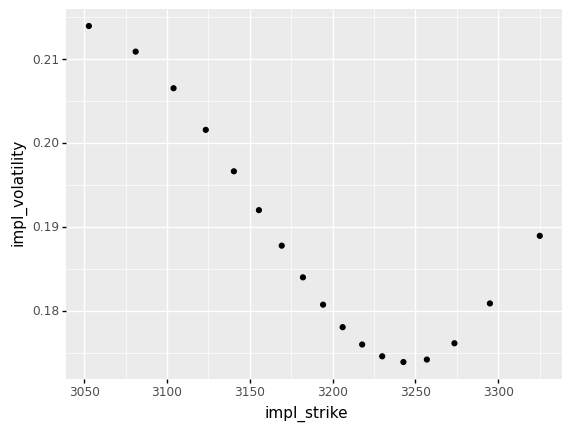

<ggplot: (110551377541)>

In [85]:
from plotnine import *
# vol_df = pd.read_csv(path,usecols=['date', 'days', 'impl_volatility', 'impl_strike', 'cp_flag'])

(
ggplot(drawVol,aes(x='impl_strike',y='impl_volatility'))#创建图象，传入数据来源和映射
+ geom_point()#建立几何对象，画直方图
)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'IVs for date: 20200605 cp_flag: C')

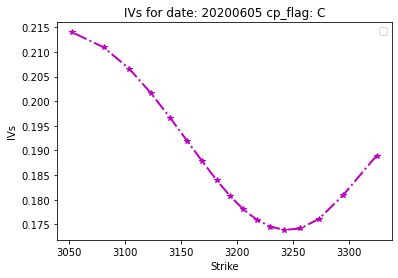

In [86]:
plt.figure()
plt.plot(drawVol['impl_strike'],drawVol['impl_volatility'],'m*-.',linewidth=2)
plt.legend()
plt.xlabel("Strike")
plt.ylabel("IVs")
plt.title('IVs for date: %d cp_flag: %s'%(date, cp_flag))